# Importing libraries

In [37]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_gaussian_quantiles, make_blobs
import numpy as np

# Create dataset

In [38]:
# Generate synthetic dataset
# features, targets = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, class_sep=1.5, flip_y=0, weights=[0.5, 0.5], random_state=20)

# features, targets = make_gaussian_quantiles(cov=3., n_samples=10000, n_features=2, n_classes=2, random_state=1)

features, targets = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.5, random_state=42)


In [39]:
# Convert features and targets to PyTorch tensors
features = torch.Tensor(features)
# Convert targets to long type for classification
targets = torch.Tensor(targets).long()

# Create DataLoader for our synthetic dataset
dataset = TensorDataset(features, targets)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

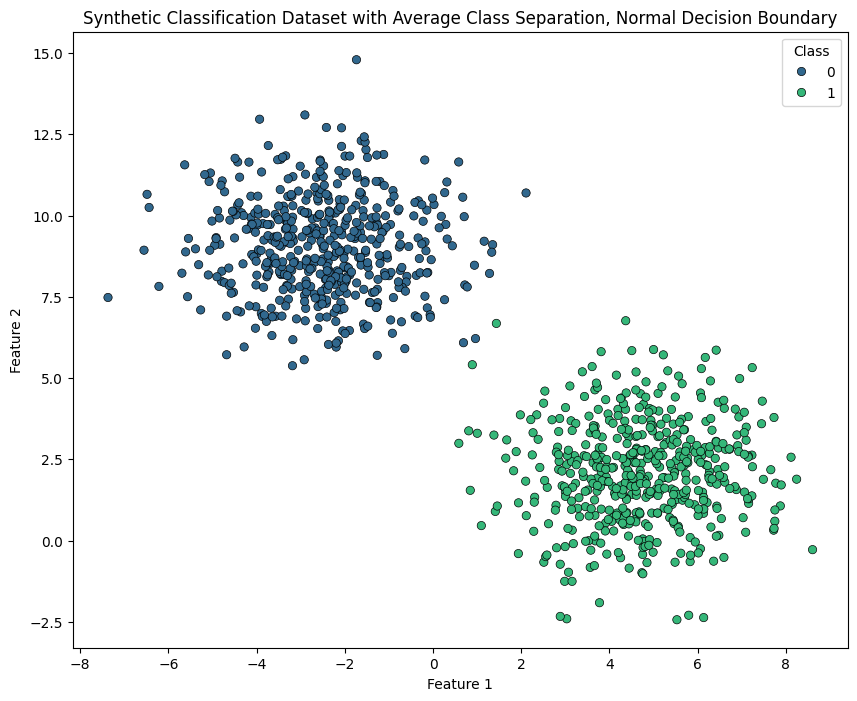

In [40]:
# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=targets, palette='viridis', edgecolor='k')
plt.title("Synthetic Classification Dataset with Average Class Separation, Normal Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Class', loc='upper right')
plt.show()

# Construct models

In [41]:
class SimpleMLP(nn.Module):
    # Initialize the layers of the MLP
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Activation function
        self.relu = nn.ReLU()
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Output layer
        self.fc3 = nn.Linear(hidden_size, num_classes)

    # Define the forward pass
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [42]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation_func=nn.ReLU()):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(activation_func)
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [43]:
# Number of features in the dataset
input_size = 2
# Size of the hidden layers
hidden_size = 16

# More general version of above
hidden_sizes = [20, 10]
# Number of output classes (2 for binary classification)
num_classes = 2

# Model instantiation
# simple_model = SimpleMLP(input_size, hidden_size=20, num_classes=2)
model = MLP(input_size, hidden_sizes, num_classes, activation_func=nn.ReLU())


'''Activation Function'''
# model.activation_func = nn.ReLU()
# model.activation_func = nn.Tanh()
# model.activation_func = nn.Sigmoid()

'''Loss Function (Criterion)'''
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()

'''Optimizer '''
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

In [44]:
# Convert features and targets to tensor for PyTorch
features_tensor = torch.tensor(features, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.long)

# Create a DataLoader to feed data into the model
dataset = TensorDataset(features_tensor, targets_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

def train_model(model, criterion, optimizer, dataloader, num_epochs=100):
    # Set the model to training mode
    model.train()
    # Initialize a list to store the loss values
    loss_history = []

    # Loop over the dataset multiple times
    for epoch in range(num_epochs):
        # Iterate over the data
        for inputs, labels in dataloader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass: compute the output of the model
            outputs = model(inputs)
            # Compute the loss
            loss = criterion(outputs, labels)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()

        # Store the loss value for this epoch
        loss_history.append(loss.item())

    # Return the trained model and the loss history
    return model, loss_history

<ipython-input-44-ee9945b71b25>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_tensor = torch.tensor(features, dtype=torch.float32)
<ipython-input-44-ee9945b71b25>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_tensor = torch.tensor(targets, dtype=torch.long)


## Plotting functions

In [45]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # step size in the mesh
    h = 0.02
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    # Set the model to evaluation mode
    model.eval()
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = np.argmax(Z.detach().numpy(), axis=1)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

In [46]:
def plot_loss_history(loss_history, title='Model Loss Over Epochs'):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, marker='o', linestyle='-', color='blue')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.show()

# Training model

In [47]:
trained_model, loss_history = train_model(model, criterion, optimizer, dataloader, num_epochs=100)

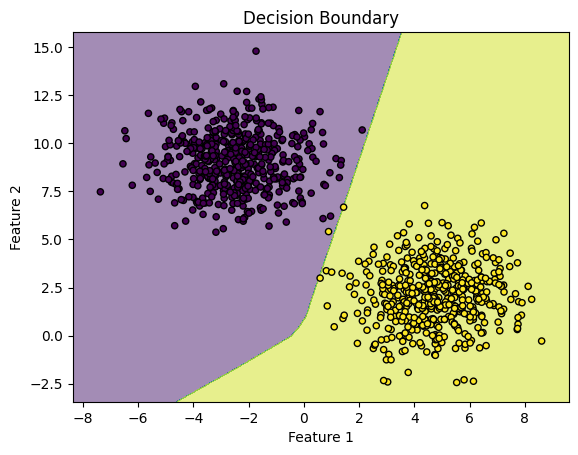

In [48]:
plot_decision_boundary(trained_model, features.numpy(), targets.numpy())
plt.show()

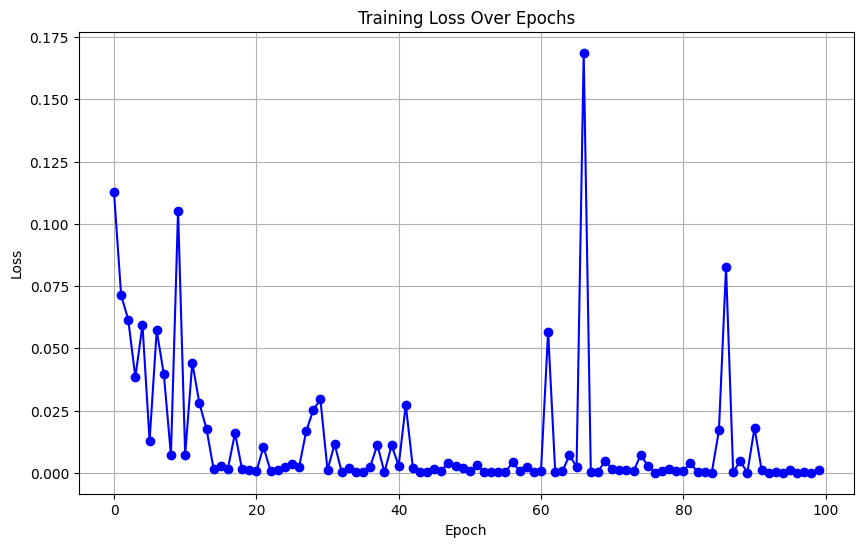

In [49]:
plot_loss_history(loss_history, title='Training Loss Over Epochs')